<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

## Import Libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## Get Data

In [9]:
data_origin = pd.read_csv('/content/drive/MyDrive/#1 ALK RVP CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [10]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin['RVP'] < 70) & (data_origin['T'] > 120)]
data.iloc[:, 1] += 273.15     # to Absolute
data.iloc[:, 2] += 101.325    # to Absolute
data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,RVP,T,P,F
2014-09-16,35.5,409.936039,436.615024,89.866631
2014-09-17,33.5,411.923619,439.539453,89.465610
2014-09-18,34.4,411.249435,440.881301,91.788269
2014-09-19,34.3,410.475546,437.095474,96.439654
2014-09-20,35.2,410.551238,451.085975,91.357863
...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000
2022-06-27,50.9,403.708482,486.321257,85.722808
2022-06-28,56.8,402.141628,504.938888,84.932767
2022-06-29,50.9,402.835703,480.513489,79.402347


In [11]:
A = 7.00961   # Temperature in Celsius
B = 1022.48
C = 248.145
P_ref = (335 / 101.325 + 1) * 760   # kPa to mmHg(Absolute)
conv = 760 / 101.325    # kPa to mmHg conversion factor
data['PCT'] = data.iloc[:, 1] + B * np.log10(P_ref / (data.iloc[:, 2] * conv)) / (A - np.log10(P_ref)) / (A - np.log10(data.iloc[:, 2] * conv))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RVP,T,P,F,PCT
2014-09-16,35.5,409.936039,436.615024,89.866631,409.911877
2014-09-17,33.5,411.923619,439.539453,89.465610,411.656493
2014-09-18,34.4,411.249435,440.881301,91.788269,410.871233
2014-09-19,34.3,410.475546,437.095474,96.439654,410.411384
2014-09-20,35.2,410.551238,451.085975,91.357863,409.336512
...,...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000,401.630900
2022-06-27,50.9,403.708482,486.321257,85.722808,399.710220
2022-06-28,56.8,402.141628,504.938888,84.932767,396.733150
2022-06-29,50.9,402.835703,480.513489,79.402347,399.285613


## Set 'n' and 'information'

In [12]:
n = 10
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE


# Poly T, P

## LinearRegression

In [13]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []

vars = 'Poly T, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [14]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                  'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.570138,0.565014,0.569934,0.430066,1.60829,4.817374


## Ridge

### Ridge (alpha = 0.001)

In [15]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [16]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.001,Standard,0.570626,0.568137,0.570379,0.429621,1.608305,4.812387


### Ridge (alpha = 0.01)

In [17]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [18]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.01,Standard,0.574959,0.555531,0.570074,0.429926,1.609147,4.815809


### Ridge (alpha = 0.1)

In [19]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [20]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.1,Standard,0.564717,0.570335,0.566777,0.433223,1.614047,4.852738


### Ridge (alpha = 1)

In [21]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [22]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,1,Standard,0.564155,0.563831,0.5645,0.4355,1.617659,4.878239


### Ridge (alpha = 10)

In [23]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [24]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,10,Standard,0.561955,0.547009,0.558463,0.441537,1.627068,4.945861


### Ridge (alpha = 100)

In [25]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [26]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,100,Standard,0.551248,0.55682,0.553409,0.446591,1.631057,5.002478


## Lasso

### Lasso (alpha = 0.001)

In [27]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [28]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.001,Standard,0.564515,0.5658,0.565306,0.434694,1.615257,4.869218


### Lasso (alpha = 0.01)

In [29]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [30]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.01,Standard,0.56459,0.535207,0.557897,0.442103,1.627637,4.952207


### Lasso (alpha = 0.1)

In [31]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [32]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.1,Standard,0.553935,0.551406,0.553593,0.446407,1.628532,5.000412


# Poly PCT, P

## LinearRegression

In [33]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [34]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",LinearRegression,NaN,Standard,0.569869,0.571694,0.570437,0.429563,1.608837,4.811737


## Ridge

### Ridge (alpha = 0.001)

In [35]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [36]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.001,Standard,0.566498,0.580458,0.570566,0.429434,1.609055,4.810298


### Ridge (alpha = 0.01)

In [37]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [38]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.01,Standard,0.574046,0.556913,0.56997,0.43003,1.609486,4.816966


### Ridge (alpha = 0.1)

In [39]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [40]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.1,Standard,0.568288,0.566779,0.568294,0.431706,1.611431,4.835742


### Ridge (alpha = 1)

In [41]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [42]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,1,Standard,0.5645,0.566589,0.565307,0.434693,1.616449,4.869203


### Ridge (alpha = 10)

In [43]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [44]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,10,Standard,0.560493,0.566327,0.562292,0.437708,1.621678,4.902973


### Ridge (alpha = 100)

In [45]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [46]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,100,Standard,0.554872,0.569078,0.559387,0.440613,1.623753,4.935513


## Lasso

### Lasso (alpha = 0.001)

In [47]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [48]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.001,Standard,0.563814,0.569396,0.565598,0.434402,1.615175,4.86594


### Lasso (alpha = 0.01)

In [49]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [50]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.01,Standard,0.558133,0.568022,0.560962,0.439038,1.623176,4.91787


### Lasso (alpha = 0.1)

In [51]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [52]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.1,Standard,0.558169,0.561398,0.559307,0.440693,1.621405,4.93641


# Poly PCT, P, F

## LinearRegression

In [53]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [54]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",LinearRegression,NaN,Standard,0.59272,0.562264,0.585854,0.414146,1.57183,4.639042


## Ridge

### Ridge (alpha = 0.001)

In [55]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [56]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.001,Standard,0.591771,0.570089,0.585869,0.414131,1.572915,4.638879


### Ridge (alpha = 0.01)

In [57]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [58]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.01,Standard,0.588918,0.574843,0.585906,0.414094,1.571448,4.638463


### Ridge (alpha = 0.1)

In [59]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [60]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.1,Standard,0.585096,0.570382,0.581499,0.418501,1.574978,4.687825


### Ridge (alpha = 1)

In [61]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [62]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,1,Standard,0.580518,0.564173,0.577121,0.422879,1.579726,4.736868


### Ridge (alpha = 10)

In [63]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [64]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,10,Standard,0.572288,0.57472,0.574068,0.425932,1.583517,4.771061


### Ridge (alpha = 100)

In [65]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [66]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,100,Standard,0.570434,0.573085,0.571492,0.428508,1.586286,4.799921


## Lasso

### Lasso (alpha = 0.001)

In [67]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [68]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+01, tolerance: 2.289e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.873e+00, tolerance: 2.209e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.001,Standard,0.578317,0.576563,0.577714,0.422286,1.578305,4.730222


### Lasso (alpha = 0.01)

In [69]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [70]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.01,Standard,0.575424,0.56289,0.57272,0.42728,1.584742,4.786167


### Lasso (alpha = 0.1)

In [71]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [72]:
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.1,Standard,0.554897,0.610498,0.569424,0.430576,1.591416,4.823087


# Poly T, P, F

## LinearRegression

In [73]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [74]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",LinearRegression,NaN,Standard,0.590055,0.571105,0.585953,0.414047,1.573172,4.63794


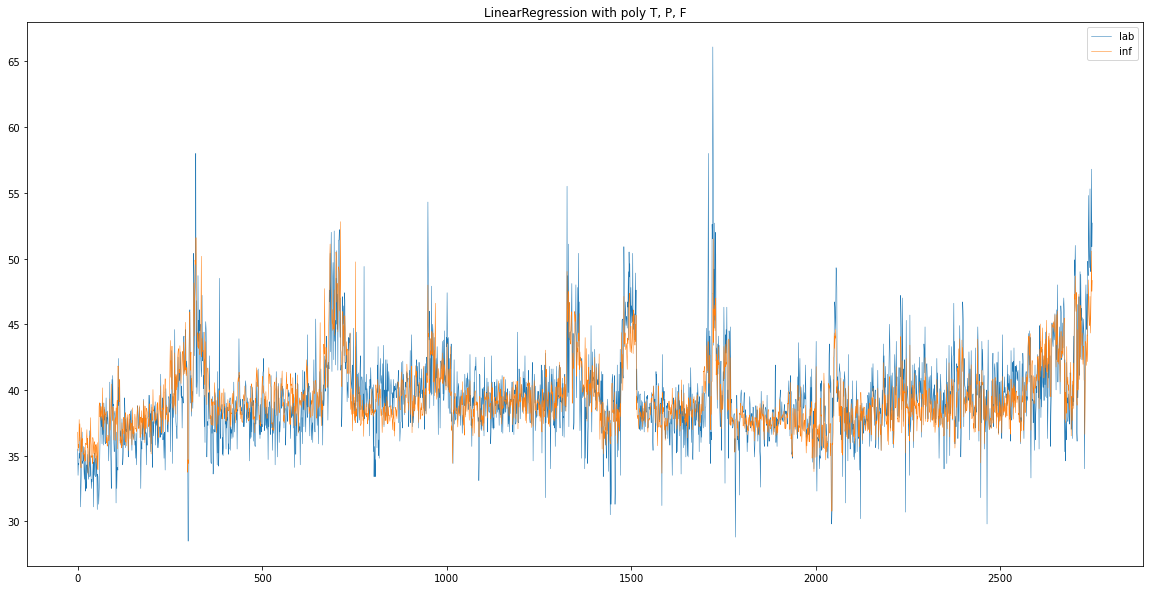

In [75]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 0.5)
plt.plot(np.arange(2750), inferential, label = 'inf', lw = 0.5)
plt.legend()
plt.title('LinearRegression with poly T, P, F')
plt.show()

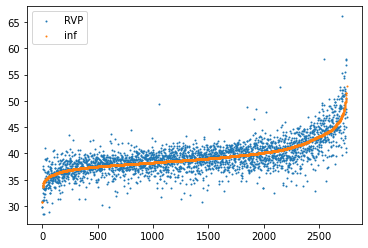

In [76]:
test = pd.DataFrame(target)
test['inf'] = inferential
# test = test.sort_values(by = 'RVP')
test = test.sort_values(by = 'inf')
test.reset_index(drop = True)
plt.scatter(np.arange(2750), test['RVP'], label = 'RVP', s = 1)
plt.scatter(np.arange(2750), test['inf'], label = 'inf', s = 1)
plt.legend()

## Ridge

### Ridge (alpha = 0.001)

In [77]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [78]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.001,Standard,0.583592,0.591479,0.586096,0.413904,1.570948,4.636332


### Ridge (alpha = 0.01)

In [79]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [80]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.01,Standard,0.594153,0.560259,0.58593,0.41407,1.571426,4.638188


### Ridge (alpha = 0.1)

In [81]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [82]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.1,Standard,0.585636,0.569784,0.581897,0.418103,1.573751,4.68337


### Ridge (alpha = 1)

In [83]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [84]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,1,Standard,0.57593,0.577574,0.576892,0.423108,1.579808,4.739429


### Ridge (alpha = 10)

In [85]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [86]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,10,Standard,0.570446,0.566566,0.570475,0.429525,1.588825,4.811313


### Ridge (alpha = 100)

In [87]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [88]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,100,Standard,0.565889,0.557304,0.564381,0.435619,1.597742,4.879579


## Lasso

### Lasso (alpha = 0.001)

In [89]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [90]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e+01, tolerance: 2.309e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+01, tolerance: 2.312e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.001,Standard,0.573875,0.589622,0.578366,0.421634,1.57848,4.722921


### Lasso (alpha = 0.01)

In [91]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [92]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.01,Standard,0.568303,0.572017,0.569633,0.430367,1.589837,4.820742


### Lasso (alpha = 0.1)

In [93]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [94]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.1,Standard,0.553397,0.576053,0.559699,0.440301,1.610207,4.932017


# Result

In [95]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,Standard,0.570138,0.565014,1.608290,4.817374,0.569934,0.430066
0,"Poly T, P",Ridge,0.001,Standard,0.570626,0.568137,1.608305,4.812387,0.570379,0.429621
0,"Poly T, P",Ridge,0.010,Standard,0.574959,0.555531,1.609147,4.815809,0.570074,0.429926
0,"Poly T, P",Ridge,0.100,Standard,0.564717,0.570335,1.614047,4.852738,0.566777,0.433223
0,"Poly T, P",Ridge,1.000,Standard,0.564155,0.563831,1.617659,4.878239,0.564500,0.435500
0,"Poly T, P",Ridge,10.000,Standard,0.561955,0.547009,1.627068,4.945861,0.558463,0.441537
0,"Poly T, P",Ridge,100.000,Standard,0.551248,0.556820,1.631057,5.002478,0.553409,0.446591
0,"Poly T, P",Lasso,0.001,Standard,0.564515,0.565800,1.615257,4.869218,0.565306,0.434694
0,"Poly T, P",Lasso,0.010,Standard,0.564590,0.535207,1.627637,4.952207,0.557897,0.442103
0,"Poly T, P",Lasso,0.100,Standard,0.553935,0.551406,1.628532,5.000412,0.553593,0.446407


In [96]:
information.drop(['train_R2', 'test_R2', 'Scaler'], axis=1)

,Variables,Solution,Alpha,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,1.608290,4.817374,0.569934,0.430066
0,"Poly T, P",Ridge,0.001,1.608305,4.812387,0.570379,0.429621
0,"Poly T, P",Ridge,0.010,1.609147,4.815809,0.570074,0.429926
0,"Poly T, P",Ridge,0.100,1.614047,4.852738,0.566777,0.433223
0,"Poly T, P",Ridge,1.000,1.617659,4.878239,0.564500,0.435500
0,"Poly T, P",Ridge,10.000,1.627068,4.945861,0.558463,0.441537
0,"Poly T, P",Ridge,100.000,1.631057,5.002478,0.553409,0.446591
0,"Poly T, P",Lasso,0.001,1.615257,4.869218,0.565306,0.434694
0,"Poly T, P",Lasso,0.010,1.627637,4.952207,0.557897,0.442103
0,"Poly T, P",Lasso,0.100,1.628532,5.000412,0.553593,0.446407


In [97]:
grouped = information['MAE'].groupby(information['Solution']).mean()

In [98]:
grouped.mean()

1.5979390674038665

In [99]:
mins = information[['MAE', 'MSE']].groupby([information['Variables'], information['Solution']]).min()
mins

MAE       MSE
Variables      Solution                            
Poly PCT, P    Lasso             1.615175  4.865940
               LinearRegression  1.608837  4.811737
               Ridge             1.609055  4.810298
Poly PCT, P, F Lasso             1.578305  4.730222
               LinearRegression  1.571830  4.639042
               Ridge             1.571448  4.638463
Poly T, P      Lasso             1.615257  4.869218
               LinearRegression  1.608290  4.817374
               Ridge             1.608305  4.812387
Poly T, P, F   Lasso             1.578480  4.722921
               LinearRegression  1.573172  4.637940
               Ridge             1.570948  4.636332

In [100]:
max = information[['train_R2', 'test_R2']].groupby([information['Variables'], information['Solution']]).max()
max

train_R2   test_R2
Variables      Solution                            
Poly PCT, P    Lasso             0.563814  0.569396
               LinearRegression  0.569869  0.571694
               Ridge             0.574046  0.580458
Poly PCT, P, F Lasso             0.578317  0.610498
               LinearRegression  0.592720  0.562264
               Ridge             0.591771  0.574843
Poly T, P      Lasso             0.564590  0.565800
               LinearRegression  0.570138  0.565014
               Ridge             0.574959  0.570335
Poly T, P, F   Lasso             0.573875  0.589622
               LinearRegression  0.590055  0.571105
               Ridge             0.594153  0.591479

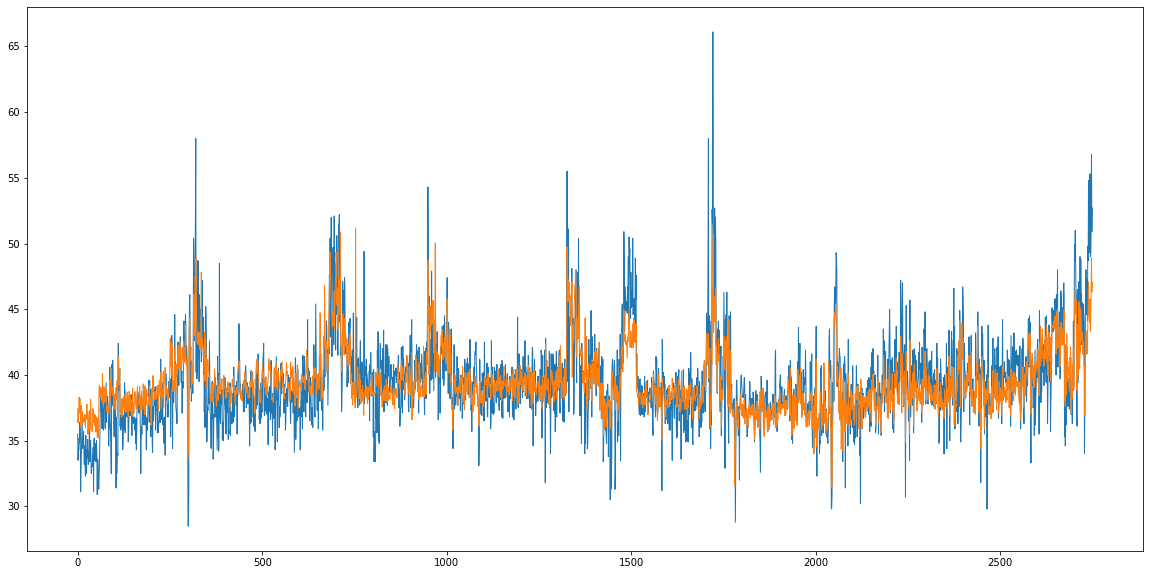

In [101]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')

In [118]:
xgb = XGBRegressor()

In [123]:
xgb.fit(train_input, train_target)

[06:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [120]:
xgb.score(train_input, train_target)

0.704074324371627

In [121]:
xgb.score(test_input, test_target)

0.5686647014234787

In [122]:
r2_score(target, xgb.predict(input_poly))

0.6421858888394639

In [110]:
inferential = xgb.predict(input_poly)

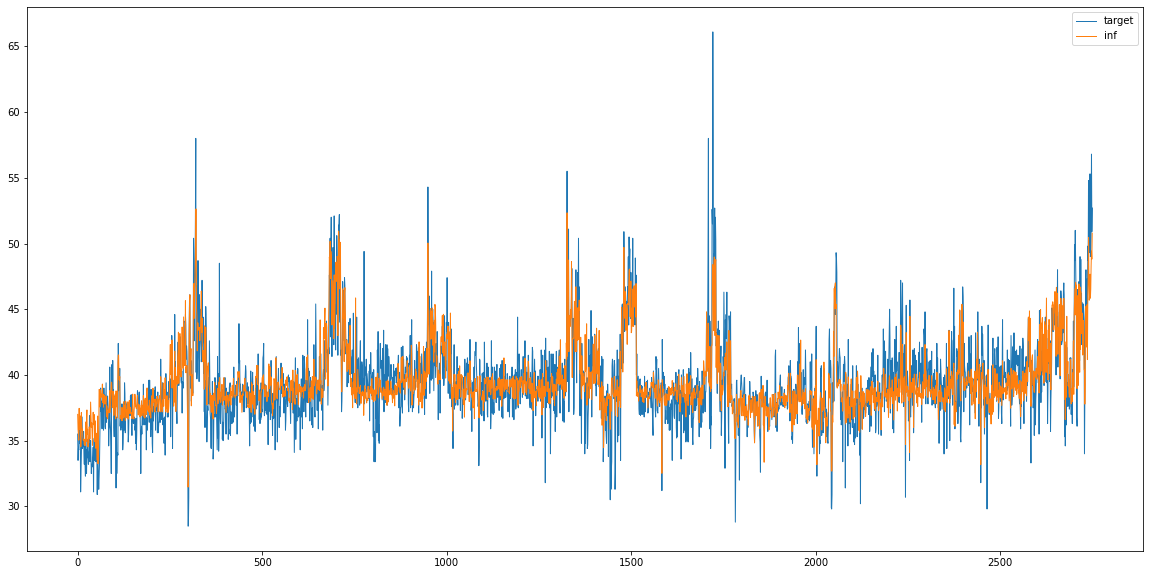

In [114]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')
plt.legend()

In [112]:
MAE(target, inferential)

1.4584541569102893

In [113]:
MSE(target, inferential)

4.008044824965023

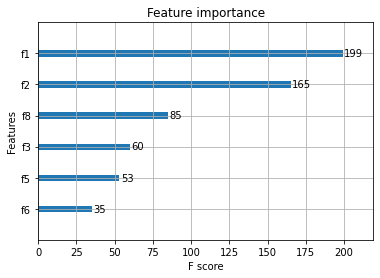

In [117]:
import xgboost
xgboost.plot_importance(xgb)